In [1]:
import torch
import torch.nn as nn
import torchvision
from torchvision import datasets, transforms, models
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
import sys, os
from glob import glob
import imageio

In [2]:
%matplotlib inline

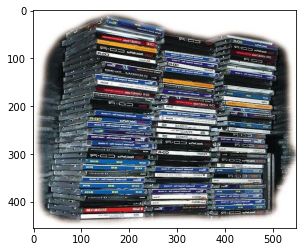

In [3]:
plt.imshow(imageio.imread('data/train/noonfood/0_555.jpg'))

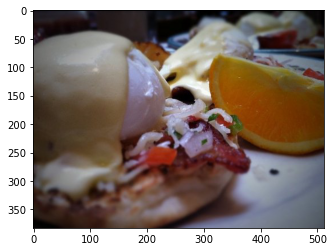

In [4]:
# Food images start with 1, non-food images start with 0
plt.imshow(imageio.imread('data/train/food/1_555.jpg'))

In [5]:
transform = transforms.Compose([
    transforms.Resize(size=256),
    transforms.CenterCrop(size=224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [6]:
train_dataset = datasets.ImageFolder('data/train', transform=transform)
test_dataset = datasets.ImageFolder('data/test', transform=transform)

In [7]:
batch_size = 128
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [8]:
vgg = models.vgg16(pretrained=True)

In [9]:
print(vgg)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [10]:
class VGGFeatures(nn.Module):
    def __init__(self, vgg):
        super(VGGFeatures, self).__init__()
        self.vgg = vgg
    
    def forward(self, X):
        out = self.vgg.features(X)
        out = self.vgg.avgpool(out)
        out = out.view(out.size(0), -1)  # flatten
        return out

In [11]:
vggf = VGGFeatures(vgg)

In [12]:
out = vggf(torch.rand(1, 3, 224, 224))
out.shape

torch.Size([1, 25088])

In [13]:
# Transform the data
Ntrain = len(train_dataset)
Ntest = len(test_dataset)
Ntrain, Ntest

(3000, 1000)

In [14]:
# Dimensionality
D = out.shape[1]

In [15]:
X_train = np.zeros((Ntrain, D))
y_train = np.zeros((Ntrain, 1))
X_test = np.zeros((Ntest, D))
y_test = np.zeros((Ntest, 1))

In [18]:
device = torch.device('cpu')

In [19]:
vggf.to(device)

VGGFeatures(
  (vgg): VGG(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=True)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace=True)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (15): ReLU(inplace=True)
      (16)

In [20]:
i = 0
with torch.no_grad():
    for inputs, targets in train_loader:
        inputs = inputs.to(device)
        output = vggf(inputs)
        sz = len(output)
        
        X_train[i:i+sz] = output.cpu().detach().numpy()
        y_train[i:i+sz] = targets.view(-1, 1).numpy()
        
        i += sz
        print(i)

128
256
384
512
640
768
896
1024
1152
1280
1408
1536
1664
1792
1920
2048
2176
2304
2432
2560
2688
2816
2944
3000


In [21]:
i = 0
with torch.no_grad():
    for inputs, targets in test_loader:
        inputs = inputs.to(device)
        output = vggf(inputs)
        sz = len(output)
        
        X_test[i:i+sz] = output.cpu().detach().numpy()
        y_test[i:i+sz] = targets.view(-1, 1).numpy()
        
        i += sz
        print(i)

128
256
384
512
640
768
896
1000


In [23]:
X_train.max(), X_train.min()

(61.9445686340332, 0.0)

In [24]:
from sklearn.preprocessing import StandardScaler

In [25]:
scaler = StandardScaler()

In [26]:
X_train2 = scaler.fit_transform(X_train)
X_test2 = scaler.transform(X_test)

In [27]:
from sklearn.linear_model import LogisticRegression
regressor = LogisticRegression()
regressor.fit(X_train2, y_train.flatten())
print('Train Score:', regressor.score(X_train2, y_train.flatten()))
print('Test Score:', regressor.score(X_test2, y_test.flatten()))

Train Score: 1.0
Test Score: 0.987


In [28]:
model = nn.Linear(D, 1)

In [40]:
device = torch.device('cpu')
model.to(device)

Linear(in_features=25088, out_features=1, bias=True)

In [41]:
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters())

In [42]:
# Make datasets
train_dataset2 = torch.utils.data.TensorDataset(
    torch.from_numpy(X_train2.astype(np.float32)),
    torch.from_numpy(y_train.astype(np.float32))
)

test_dataset2 = torch.utils.data.TensorDataset(
    torch.from_numpy(X_test2.astype(np.float32)),
    torch.from_numpy(y_test.astype(np.float32))
)

In [43]:
batch_size = 128
train_loader2 = torch.utils.data.DataLoader(train_dataset2, batch_size=batch_size, shuffle=True)
test_loader2 = torch.utils.data.DataLoader(test_dataset2, batch_size=batch_size, shuffle=False)

In [44]:
# A function to encapsulate the training loop
def batch_gd(model, criterion, optimizer, train_loader, test_loader, epochs):
    train_losses = np.zeros(epochs)
    test_losses = np.zeros(epochs)
    
    for i in range(epochs):
        t0 = datetime.now()
        train_loss = []
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            
            # zero the parameter gradients
            optimizer.zero_grad()
            
            # forward pass
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            
            # backward and optimize
            loss.backward()
            optimizer.step()
            
            train_loss.append(loss.item())
            
        # Get train loss and test loss
        train_loss = np.mean(train_loss)
        
        test_loss = []
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            test_loss.append(loss.item())
        test_loss = np.mean(test_loss)
        
        # Save losses
        train_losses[i] = train_loss
        test_losses[i] = test_loss
        
        dt = datetime.now() - t0
        print(f'Epoch {i+1}/{epochs}, Train Loss: {train_loss:.4f}, \ Test Loss: {test_loss:.4f}, Duration: {dt}')
    
    return train_losses, test_losses

In [45]:
train_losses, test_losses = batch_gd(model, criterion, optimizer, train_loader2, test_loader2, epochs=10)

Epoch 1/10, Train Loss: 0.1147, \ Test Loss: 0.0165, Duration: 0:00:01.383300
Epoch 2/10, Train Loss: 0.0093, \ Test Loss: 0.0026, Duration: 0:00:01.091080
Epoch 3/10, Train Loss: 0.0016, \ Test Loss: 0.0009, Duration: 0:00:00.574463
Epoch 4/10, Train Loss: 0.0008, \ Test Loss: 0.0006, Duration: 0:00:00.612361
Epoch 5/10, Train Loss: 0.0006, \ Test Loss: 0.0005, Duration: 0:00:00.852726
Epoch 6/10, Train Loss: 0.0005, \ Test Loss: 0.0004, Duration: 0:00:00.862683
Epoch 7/10, Train Loss: 0.0004, \ Test Loss: 0.0004, Duration: 0:00:00.663225
Epoch 8/10, Train Loss: 0.0004, \ Test Loss: 0.0003, Duration: 0:00:00.567482
Epoch 9/10, Train Loss: 0.0003, \ Test Loss: 0.0003, Duration: 0:00:00.628320
Epoch 10/10, Train Loss: 0.0003, \ Test Loss: 0.0003, Duration: 0:00:00.662228


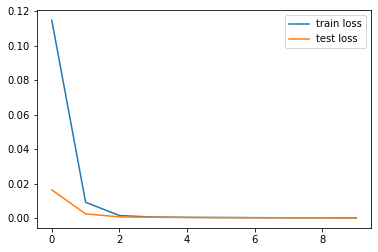

In [46]:
# Plot the train loss and test loss per iteration
plt.plot(train_losses, label='train loss')
plt.plot(test_losses, label='test loss')
plt.legend()

In [48]:
# Accuracy
n_correct = 0.
n_total = 0.
for inputs, targets in train_loader2:
    # move data to GPU
    inputs, targets = inputs.to(device), targets.to(device)
    
    
    # forward pass
    outputs = model(inputs)
    
    # Get prediction
    # torch.max returns both max and argmax
    _, predictions = torch.max(outputs, 1)
    
    # update counts
    n_correct += (predictions == targets).sum().item()
    n_total += targets.shape[0]

train_acc = n_correct / n_total


n_correct = 0.
n_total = 0.
for inputs, targets in test_loader2:
    # move data to GPU
    inputs, targets = inputs.to(device), targets.to(device)
    
    # forward pass
    outputs = model(inputs)
    
    # Get prediction
    # torch.max returns both max and argmax
    _, predictions = torch.max(outputs, 1)
    
    # update counts
    n_correct += (predictions == targets).sum().item()
    n_total += targets.shape[0]

test_acc = n_correct / n_total

print(f'Train accuracy: {train_acc:.4f}, Test accuracy: {test_acc:.4f}')

Train accuracy: 63.1600, Test accuracy: 64.0000
